In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil import parser
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
import plotly.graph_objects as go


In [2]:
# Step 1: import the data
df1 = pd.read_csv("events.csv")
df2 = pd.read_csv('pre2008events.csv')
df = pd.concat([df1,df2])

# Step 2: Making date as 'datetime' eliminating NA
df['ev_date'] = pd.to_datetime(df['ev_date'], errors='coerce')
df = df.dropna(subset=['ev_date'])
df['ev_date']

C:\Users\smith\AppData\Local\Temp\ipykernel_39992\1103644042.py:2: DtypeWarning: Columns (0,10,31,51) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv("events.csv")
C:\Users\smith\AppData\Local\Temp\ipykernel_39992\1103644042.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['ev_date'] = pd.to_datetime(df['ev_date'], errors='coerce')


0       2008-01-10
1       2008-01-01
2       2008-01-01
3       2008-01-03
4       2008-01-02
           ...    
62997   2006-05-28
62998   2007-11-09
62999   1992-09-05
63000   1979-09-17
63001   2000-09-17
Name: ev_date, Length: 92228, dtype: datetime64[ns]

In [3]:
# Step 3: grouping daily accidents
df_daily = df.groupby('ev_date').size().reset_index(name='N')
df_daily = df_daily.sort_values('ev_date')

## deleting too old data(1948, 1962, 1974)
df_daily = df_daily[(df_daily.ev_date.dt.year > 1981) & (df_daily.ev_date.dt.year < 2026)]

# Step 4: regulating absent dates
all_dates = pd.DataFrame({'ev_date': pd.date_range(start=df_daily['ev_date'].min(), 
                                                    end=df_daily['ev_date'].max(), freq='D')})
df_daily = pd.merge(all_dates, df_daily, on='ev_date', how='left')
df_daily['N'] = df_daily['N'].fillna(0).astype(int)

print(df_daily)
print(all_dates)

         ev_date   N
0     1982-01-01   4
1     1982-01-02  12
2     1982-01-03   7
3     1982-01-04   5
4     1982-01-05   9
...          ...  ..
15913 2025-07-27   3
15914 2025-07-28   5
15915 2025-07-29   1
15916 2025-07-30   0
15917 2025-07-31   2

[15918 rows x 2 columns]
         ev_date
0     1982-01-01
1     1982-01-02
2     1982-01-03
3     1982-01-04
4     1982-01-05
...          ...
15913 2025-07-27
15914 2025-07-28
15915 2025-07-29
15916 2025-07-30
15917 2025-07-31

[15918 rows x 1 columns]


In [4]:
# adding the column of year and month
df_daily['year'] = df_daily['ev_date'].dt.year
df_daily['month'] = df_daily['ev_date'].dt.month

# Step 5: calculation monthly
df_monthly = df_daily.groupby(['year', 'month'])['N'].sum().reset_index(name='incident_count')
df_monthly = df_monthly.sort_values(by=['year', 'month'])

# Making Time series data
start_year = df_monthly['year'].iloc[0]
start_month = df_monthly['month'].iloc[0]
ts_data = df_monthly['incident_count'].to_numpy()

print(df_monthly)
print(start_year)

     year  month  incident_count
0    1982      1             203
1    1982      2             227
2    1982      3             278
3    1982      4             301
4    1982      5             382
..    ...    ...             ...
518  2025      3             117
519  2025      4             101
520  2025      5              93
521  2025      6             137
522  2025      7             135

[523 rows x 3 columns]
1982


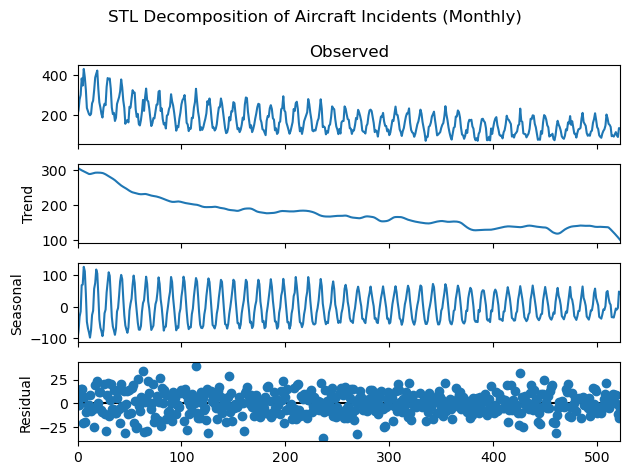

In [5]:
# Time series decomposition
stl = STL(ts_data, period=12)  # period is 12 for monthly analysis
result = stl.fit()

trend = result.trend
seasonal = result.seasonal
fit = trend + seasonal

# STL decomposition plot
result.plot()
plt.suptitle("STL Decomposition of Aircraft Incidents (Monthly)")
plt.tight_layout()
plt.show()


In [6]:
# Making dataframe for visulaization

df_monthly['Time'] = df_monthly['month'].astype(str) + "/" + df_monthly['year'].astype(str)
df_monthly['trend'] = trend
df_monthly['fit'] = fit

df_monthly

,year,month,incident_count,Time,trend,fit
0,1982,1,203,1/1982,305.991198,204.566378
1,1982,2,227,2/1982,304.164613,228.258720
2,1982,3,278,3/1982,302.393051,270.829434
3,1982,4,301,4/1982,300.688021,285.791855
4,1982,5,382,5/1982,299.056578,367.387311
...,...,...,...,...,...,...
518,2025,3,117,3/2025,114.092560,108.402866
519,2025,4,101,4/2025,110.746977,101.783344
520,2025,5,93,5/2025,107.307789,103.734067
521,2025,6,137,6/2025,103.765716,151.892381


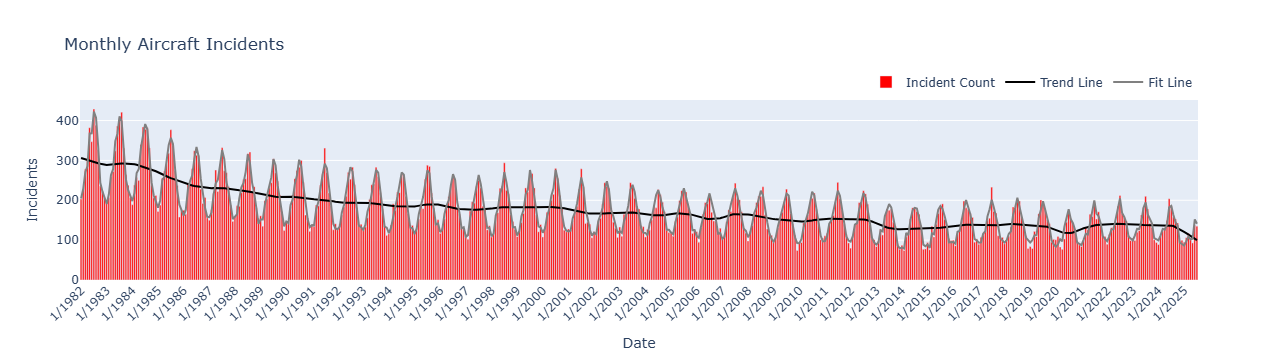

In [10]:
# Making a plot

fig = go.Figure()

fig.add_trace(go.Bar(x=df_monthly['Time'], y=df_monthly['incident_count'], name='Incident Count', marker_color='red'))

fig.add_trace(go.Scatter(x=df_monthly['Time'], y=df_monthly['trend'], mode='lines', name='Trend Line', line=dict(color='black')))

fig.add_trace(go.Scatter(x=df_monthly['Time'], y=df_monthly['fit'], mode='lines', name='Fit Line', line=dict(color='grey')))

fig.update_layout(title='Monthly Aircraft Incidents', xaxis_title='Date', yaxis_title='Incidents',
    xaxis=dict(tickangle=-45, tickmode='array', tickvals=df_monthly['Time'][::12]),
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
    hovermode='x unified'  # When you move the mouse along the x-axis, 
                       # all traces that share that same x value will display their y values together in one combined tooltip box.

fig.show()

In [23]:
event_dates = {
    "TCAS": "1993-01-01",
    "9/11": "2001-09-01",
    "ADS-B": "2020-01-01"
}

# datetime
event_dates = {k: pd.to_datetime(v) for k, v in event_dates.items()}


C:\Users\smith\AppData\Local\Temp\ipykernel_12524\1014826597.py:1: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



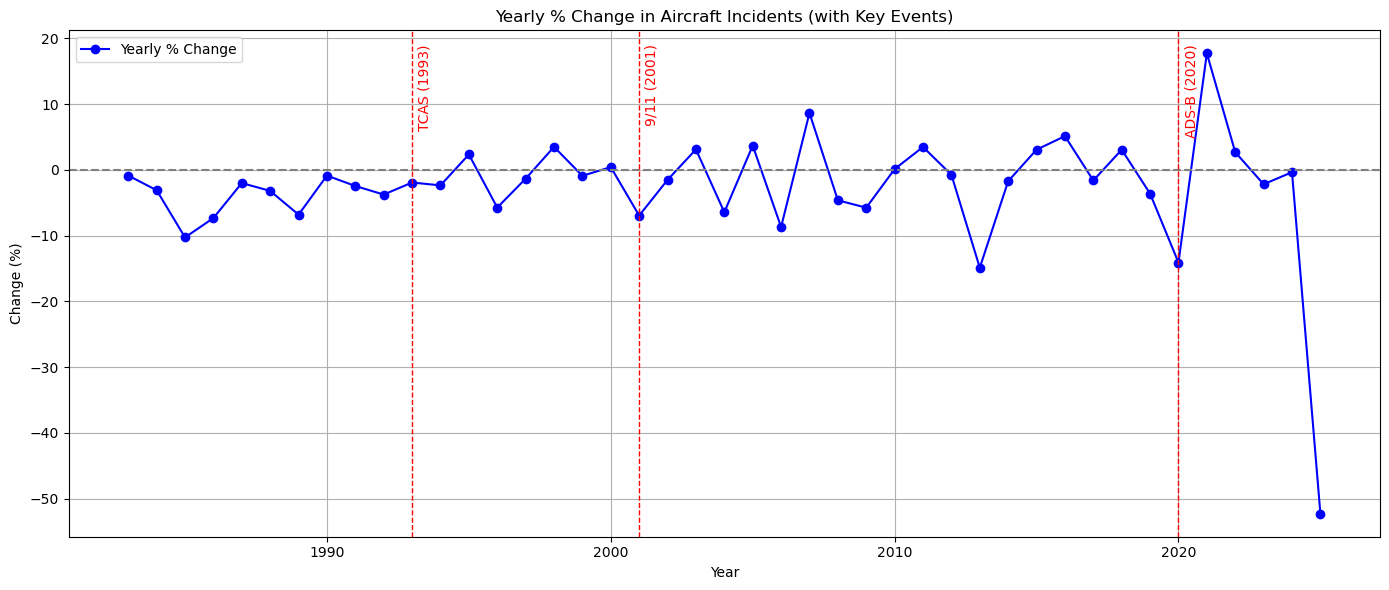

In [26]:
df_monthly['Time'] = pd.to_datetime(df_monthly['Time'])
df_monthly['Year'] = df_monthly['Time'].dt.year


df_yearly = df_monthly.groupby('Year')['incident_count'].sum().reset_index()


df_yearly['change'] = df_yearly['incident_count'].diff()
df_yearly['change_pct'] = df_yearly['incident_count'].pct_change() * 100

event_years = {
    "TCAS (1993)": 1993,
    "9/11 (2001)": 2001,
    "ADS-B (2020)": 2020
}

plt.figure(figsize=(14, 6))
plt.plot(df_yearly['Year'], df_yearly['change_pct'], marker='o', linestyle='-', color='blue', label='Yearly % Change')


plt.axhline(y=0, color='gray', linestyle='--')

for label, year in event_years.items():
    plt.axvline(x=year, color='red', linestyle='--', linewidth=1)
    plt.text(year + 0.2, plt.ylim()[1]*0.9, label, color='red', rotation=90, verticalalignment='top')


plt.title("Yearly % Change in Aircraft Incidents (with Key Events)")
plt.xlabel("Year")
plt.ylabel("Change (%)")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

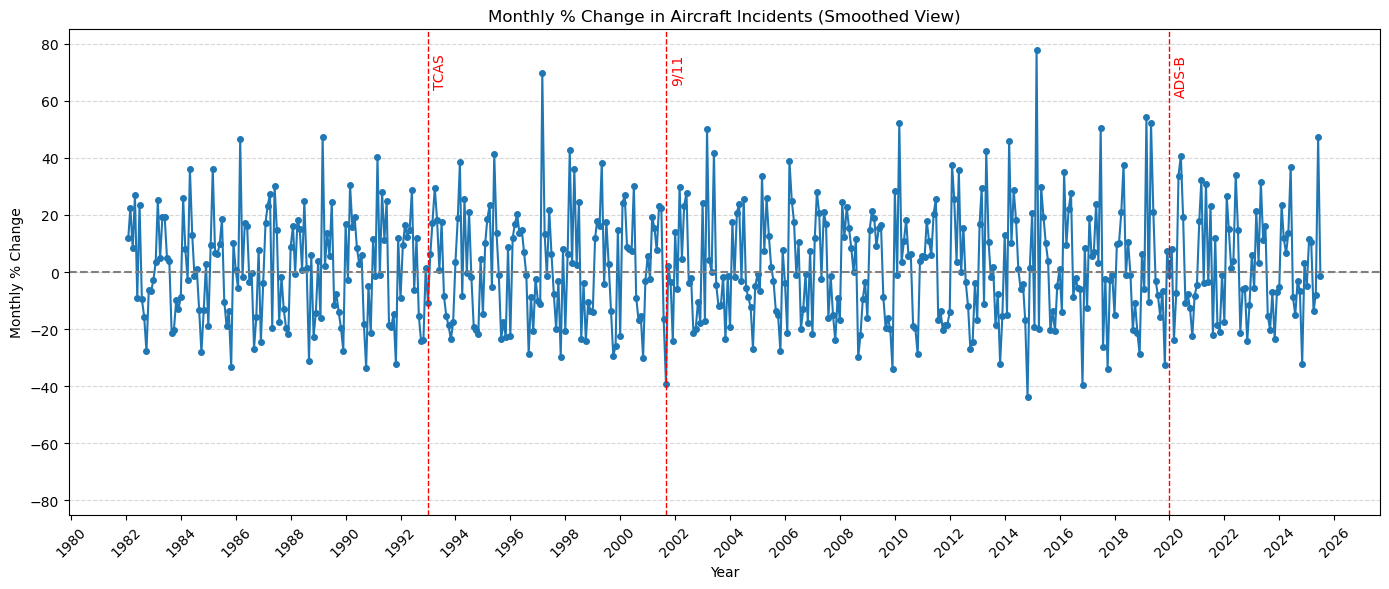

In [40]:
import matplotlib.dates as mdates

df_monthly['change_pct'] = df_monthly['incident_count'].pct_change() * 100


# Plot
plt.figure(figsize=(14,6))
plt.plot(df_monthly['Time'], df_monthly['change_pct'], marker='o', linestyle='-', markersize=4)

plt.gca().xaxis.set_major_locator(mdates.YearLocator(2)) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

plt.ylim(-85, 85) 

plt.title("Monthly % Change in Aircraft Incidents (Smoothed View)")
plt.xlabel("Year")
plt.ylabel("Monthly % Change")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.axhline(y=0, color='gray', linestyle='--')

for label, year in event_dates.items():
    plt.axvline(x=year, color='red', linestyle='--', linewidth=1)
    plt.text(year + pd.Timedelta(days=60), plt.ylim()[1]*0.9, label,
         color='red', rotation=90, verticalalignment='top')


plt.tight_layout()
plt.show()


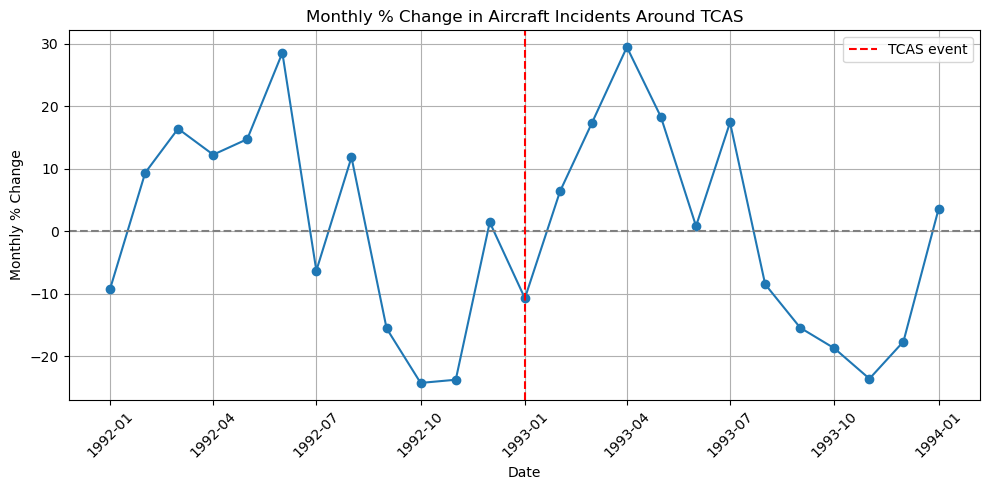

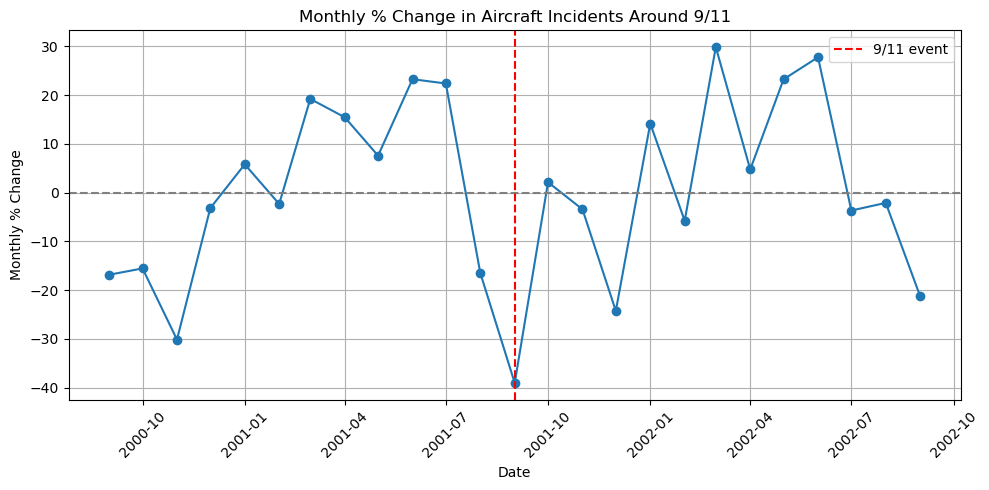

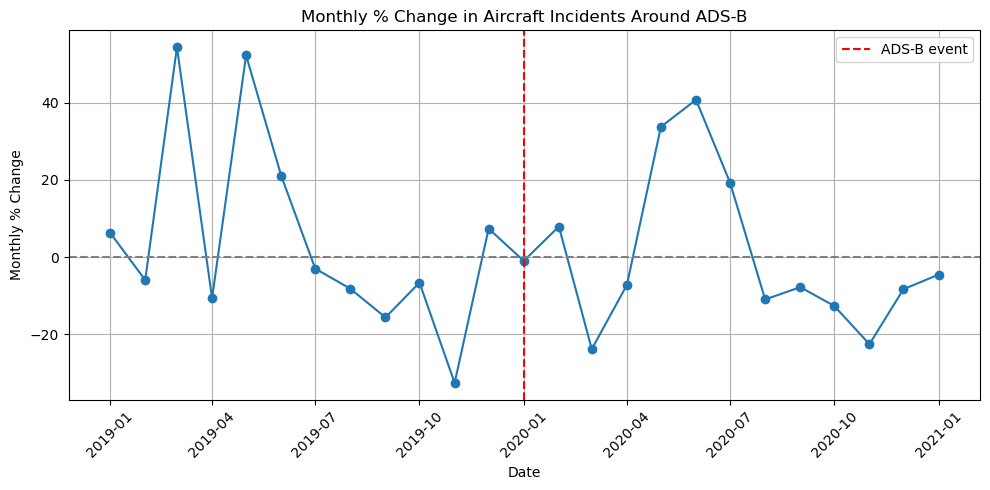

In [30]:
df_monthly['Time'] = pd.to_datetime(df_monthly['Time'])

window_months = 12

for event, date in event_dates.items():
    mask = (df_monthly['Time'] >= date - pd.DateOffset(months=window_months)) & \
           (df_monthly['Time'] <= date + pd.DateOffset(months=window_months))
    subset = df_monthly.loc[mask]

    plt.figure(figsize=(10, 5))
    plt.plot(subset['Time'], subset['change_pct'], marker='o', linestyle='-')
    plt.axhline(y=0, color='gray', linestyle='--')
    plt.axvline(x=date, color='red', linestyle='--', label=f"{event} event")

    plt.title(f"Monthly % Change in Aircraft Incidents Around {event}")
    plt.xlabel("Date")
    plt.ylabel("Monthly % Change")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
